In [2]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd 
from scipy.optimize import curve_fit
import scipy.stats as stat

# Functions 
> Current $i(t)$
$$
i(t) =  \frac{V_0 \omega \cdot \sin(\omega t -\phi)}{L \sqrt{(\omega_0^2 -\omega^2)^2 +\omega^2 \Gamma^2}}
$$

> Voltage $v(t)$
$$
v_R(t) = R\cdot i(t) = R\cdot \left( \frac{V_0 \omega \cdot \sin(\omega t -\phi) }{L\sqrt{(\omega_0^2-\omega^2)^2 +\omega^2\Gamma^2}}\right )
$$

In [3]:
# Constants and errors for RCL
R = 99.8        #ohms 
Rsig = 0.2      #ohms

Rl = 103.4      #ohms 
Rlsig = 0.2     #ohms

L = 15E-3       #H 
Lsig = 1E-3     #H

C = (10.08)*10**(-9)    #Farads 
Csig = .05E-9           #Farada

# Calculate $R_T$ and its error prop
- <span style="color:red"> **Calculation in Excel**</span>


$$
R_T = R + R_L
$$

> $$\sigma_{R_T}^2 = \left(\frac{\partial R_T}{\partial R} \right)^2 \cdot \sigma_{R}^2 + \left(\frac{\partial R_T}{\partial R_L} \right)^2 \cdot \sigma_{R_L}^2$$

> $$\sigma_{R_T}^2 = \left( 1 \right)^2 \sigma_{R}^2 + \left( 1 \right)^2 \sigma_{R_L}^2$$

$$
\sigma_{R_T}^2 = \sigma_{R}^2 +  \sigma_{R_L}^2
$$

In [4]:
#for data manipulation -not curvefit
def R_tVar(Rsig, RLsig):
    RtVar = Rsig**2 + RLsig**2 
    return RtVar

Rt = R + Rl
Rtvar = R_tVar(Rsig, Rlsig)
Gamma = Rt/L

# Calculate Theoretical resonant frequency $\omega_0$ and its error prop
>> This is from known characteristics (ideal)

$$
w_0 = \frac{1}{\sqrt{LC}}
$$

> $$\sigma_{\omega_0}^2 = \left(\frac{\partial \omega_0}{\partial L} \right)^2 \cdot \sigma_{L}^2 + \left(\frac{\partial \omega_0}{\partial C} \right)^2 \cdot \sigma_{C}^2$$

> $$\sigma_{\omega_0}^2 = \left(\frac{-1}{2\cdot L^{\frac{3}{2}}\cdot C^{\frac{1}{2}}} \right)^2 \cdot \sigma_{L}^2 + \left(\frac{-1}{2\cdot L^{\frac{1}{2}}\cdot C^{\frac{3}{2}}}\right)^2 \cdot \sigma_{C}^2$$

 $$\sigma_{\omega_0}^2 = \left(\frac{1}{2\cdot L^{\frac{3}{2}}\cdot C^{\frac{1}{2}}} \right)^2 \cdot \sigma_{L}^2 + \left(\frac{1}{2\cdot L^{\frac{1}{2}}\cdot C^{\frac{3}{2}}}\right)^2 \cdot \sigma_{C}^2$$

In [5]:
#for data manipulation -not curvefit
def Omega0(L,C): 
    """ Input LC in standard units 
        Return resonant angular frequency"""
    w0 = 1/np.sqrt(L*C)
    return w0 

def Freq0(w0): 
    """ Input omega0
        Return frequecny0"""
    f0 =w0/(2*np.pi)
    return f0 

def OmegaVar(L,Lsig, C, Csig): 
    """ Input L,Lsig,C,Csig in standard units 
        Return omega0 Variance"""
    Lvar = Lsig**2
    Cvar = Csig**2
    
    t1 = 2*(L**(3/2))*np.sqrt(C)
    t2 = 1/t1
    term1 = (t2**2)*Lvar
    
    t3 = 2*np.sqrt(L)*(C**(3/2))
    t4 = 1/t3
    term2 = (t4**2)*Cvar

    w0var = term1 + term2

    return w0var 

In [6]:
# Theoretical Values
w0 = Omega0(L,C)
w0var = OmegaVar(L, Lsig, C, Csig)
w0sig = np.sqrt(w0var)
f0 = Freq0(w0)
f0sig = w0sig/(2*np.pi)

# Calculate the phase $\phi$ and its error

- td = Time difference measured by oscilloscope 
- <span style="color:red">**Calculation in Excel**</span>


$$
\phi = 360 \cdot \frac{td}{P} = deg
$$

$$
\phi = 2\pi \cdot \frac{td}{P} = rad
$$

> $$\sigma_\phi^2 = \left(\frac{\partial \phi}{\partial td} \right)^2 \cdot \sigma_{td}^2 + \left(\frac{\partial \phi}{\partial P} \right)^2 \cdot \sigma_{P}^2$$

 $$ 
 \sigma_\phi^2 = \left(360 \cdot \frac{1}{P}\right)^2 \cdot \sigma_{td}^2 + \left(360 \frac{td}{P^2} \right)^2\cdot \sigma_{P}^2
 $$

In [7]:
#for data manipulation -not curvefit
def Phasedeg(timediff, period): 
    """ Input time difference between waves & period of output wave
        Return the phase angle in degrees"""
    phi = 360*(timediff/period)
    return phi


def PhaseVardeg(timediff, tdsig, period, psig): 
    """ Input the time differnce, tdsig, period, psig 
        Returns the Variance of the phase angle in degress"""
    tdvar = tdsig**2
    pvar = psig**2

    t1 = 360/period
    term1 = (t1**2)*tdvar
    
    t2 = (360*timediff)/(period**2)
    term2 = (t2**2)*pvar

    phivar = term1 + term2
    return phivar

#General, used for easy calculation 
def IMax(V0,w,w0,Gamma,L):
    """ Input Input Voltage, omega, omega0, L, Gamma
        Return I max in Amps"""
    t1 = V0*w

    t2 = w0**2 - w**2
    t3 = (w*Gamma)**2
    t4 = L*np.sqrt(t2**2 +t3)

    imax =t1/t4

def vRMax(w, V0,w0,Gamma,L,R): 
    """ Input Input Voltage, omega, omega0, L, Gamma, R
        Return v_R max in volts"""
    t1 = V0*w*R

    t2 = w0**2 - w**2
    t3 = (w*Gamma)**2
    t4 = L*np.sqrt(t2**2 +t3)

    vRmax = t1/t4

# Read in data

In [8]:
RCLdata = pd.read_csv('data3.csv')

# Create some series 
# voltage
Vin = RCLdata['VIn CH1']
VinSig = RCLdata['VInSig']

Vout = RCLdata['VOut CH2']
VoutSig = RCLdata['VOutSig']

#Frequency and Angular Freq
Freq = RCLdata['Frequency Hz']
FreqSig = RCLdata['FeqSig Hz']
w = RCLdata['w']
wSig =RCLdata['wSig']

#Phase angle & parameters 
Phi = RCLdata['Phase Ch2Ch1 deg']
Phivar = RCLdata['PhaseVar deg']

Period = RCLdata['Period s']
Periodsig = RCLdata['PeriodSig s']
Timdiff = RCLdata['Timediff TD s']
Timdiffsig = RCLdata['TDSig s']

In [9]:
#check excel calculated correctly 
phi2 = Phasedeg(Timdiff,Period) # missing negastives 
phi2var = PhaseVardeg(Timdiff,Timdiffsig, Period, Periodsig)
phistd = np.sqrt(phi2var)

# CurveFit Vout Vs. $\omega$
> Created different variations due to issues with Curvefit function 
>> issue: uncertainty is large and values are not very close to the ones measured 

- Function: 
$$
 v_R(t) = R\cdot i(t) = R\cdot \left( \frac{V_0 \omega  }{L\sqrt{(\omega_0^2-\omega^2)^2 +\omega^2\Gamma^2}}\right )\cdot  \sin(\omega t -\phi)
$$
- 1. Magnitude, $\Gamma = \frac{R_T}{L} = \frac{R + R_L}{L}$
>$$
v_R(t)_{Max} = R\cdot \left(\frac{V_0 \omega }{L\sqrt{(\omega_0^2-\omega^2)^2 +\omega^2\Gamma^2}}\right)
$$

- 2. Magnitude replacing $\Gamma$
$$
v_R(t)_{Max} = R\cdot \left(\frac{V_0 \omega }{L\sqrt{((\frac{1}{\sqrt{LC}})^2-\omega^2)^2 +\omega^2(\frac{R_T}{L})^2}}\right)
$$
- 3. Magnitude in base variables 
$$
v_R(t)_{Max} = R\cdot \left(\frac{V_0 \omega }{L\sqrt{((\frac{1}{\sqrt{LC}})^2-\omega^2)^2 +\omega^2(\frac{R +R_L}{L})^2}}\right)
$$

In [10]:
# Mag. 1 
def VRMax2(w,R, w0, gamma):
    V0 = 76
    return ((R*V0*w)/L)*( (w0**2-w**2)**2 + w**2*(gamma)**2)**(-1/2)

In [11]:
# LAST ATTEMPT
def VRMax3(w, R, L, C):
    V0 = 76
    Rl = 103.4
    return ((R*V0*w)/L)*( ((L*C)**(-1) - w**2)**2 + (w**2)*((R+Rl)/L)**2)**(-1/2)

In [12]:
# fit
p02 = [90,80000,12500]
p04 = [95,0.015,1E-8]
popt2 , pcov2 = curve_fit( VRMax2,w, Vout , sigma=VoutSig, p0 = p02, absolute_sigma=True)
popt4 , pcov4 = curve_fit( VRMax3,w, Vout , sigma=VoutSig, p0= p04 , absolute_sigma=True)

In [13]:
# Check

print('\nMag1 R, w0, gamma')
for i in range(0,len(popt2)):
    print('param ',i,' = ',popt2[i], '+/-', np.sqrt(np.abs(pcov2[i,i])))

print('\nMag R,L,C')
for i in range(0,len(popt4)):
    print('param ',i,' = ',popt4[i], '+/-', np.sqrt(np.abs(pcov4[i,i])))


Mag1 R, w0, gamma
param  0  =  11.601560053455128 +/- 0.19200403299692945
param  1  =  80539.1033874292 +/- 118.67393865097493
param  2  =  19213.90983136608 +/- 391.1690636325972

Mag R,L,C
param  0  =  237.38648019704516 +/- 8540.54333983662
param  1  =  1.4685751160346631e-09 +/- 0.0009393538654847848
param  2  =  1.7355529659191734e-09 +/- 6.24813384371463e-08


In [14]:
print(f'R = \t\t{R}')
print(f'RL = \t\t{Rl}')
print(f'RT = \t\t{Rt}')
print(f'L = \t\t{L}')
print(f'C = \t\t{C}')
print(f'W0 = \t\t{w0}')
print(f'Gamma = \t{Gamma}')

R = 		99.8
RL = 		103.4
RT = 		203.2
L = 		0.015
C = 		1.008e-08
W0 = 		81325.00607904443
Gamma = 	13546.666666666666


# Plot Vout Vs $\omega$

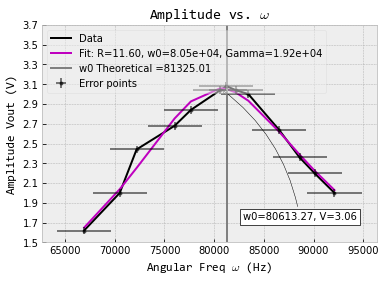

In [107]:
#style
hfont = {'fontname':'Consolas'}
plt.figure()
plt.style.use('bmh')


# Fit a line with paramaters given 
fitline = VRMax2(w, *popt2)
# fitline2 = VRMax3(w, *popt4)


def annot_max(x,y, ax=None):
    xmax = x[np.argmax(y)]
    ymax = y.max()
    text= "w0={:.2f}, V={:.2f}".format(xmax, ymax)
    if not ax:
        ax=plt.gca()
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    arrowprops=dict(arrowstyle="->",connectionstyle="arc3,rad=.2", color='black')
    kw = dict(xycoords='data',textcoords="axes fraction",
              arrowprops=arrowprops, bbox=bbox_props, ha="right", va="top")
    ax.annotate(text, xy=(xmax, ymax), xytext=(0.94,0.14), **kw)

annot_max(w,fitline)



# plot data
plt.plot(w, Vout, color = 'black', label= 'Data')
plt.plot(w,fitline, 'm', label= 'Fit: R=%1.2f, w0=%1.2e, Gamma=%1.2e' % tuple(popt2))
# plt.plot(w,fitline2, 'r', label= 'fit2')
plt.errorbar(w,Vout,yerr=VoutSig, xerr=w0sig, fmt= '.', ls = None, label= 'Error points', color = 'black', alpha =0.5)
plt.yticks(np.linspace(1.5,3.7,12))



#Labels 
plt.title("Amplitude vs. $\omega$", **hfont)
plt.ylabel("Amplitude Vout (V)", **hfont)
plt.xlabel("Angular Freq $\omega$ (Hz)", **hfont)
plt.axvline(w0, color ='gray', label =f'w0 Theoretical ={w0:.2f}')

plt.legend(loc =2,fancybox=True, framealpha=0.5)


# plt.savefig("AmpVsOmega.png", bbox_inches='tight')

# $Chi^2$

In [16]:
# By definition: 
chisq = sum( (Vout - fitline)**2 / VoutSig**2 )

# ndf = number of degrees of freedom
ndf = len(w)-len(popt2)

# prof advised not to use this 
chisq_reduced = chisq/float(ndf)

#   Note:
#       The reduced Chi2 = (Chi2/ndf) is just a "shortcut" that allows us to quickly decide if 
#       the data agrees with the model.
#     If reduced Chi2 is about equal to one: we are definitely good, because (Chi2/ndf)=1 corresponds to 
#     the p-value of 0.5

cdf = stat.chi2.cdf(chisq, df = ndf)

# For a Chisquare with a given number of degrees of freedom the p-test value: 
#       is just one minus the cummilative distribtion 
#       fucntion (CDF) of the chisquare probabilty distribution evaluated at the calculated value of ChiSq
pvalue = 1-cdf

print('Chi-square: ',chisq)
print('Degrees of freedom: ',ndf)
print('Reduced chi-square: ',chisq_reduced)
print('CDF: ', cdf)
print('p-test value: ',pvalue)


Chi-square:  36.98360129189868
Degrees of freedom:  10
Reduced chi-square:  3.698360129189868
CDF:  0.9999430356936134
p-test value:  5.696430638657546e-05


# CurveFit Phi Vs. $\omega$

$$
\tan(\phi) = \frac{\omega^2 - \omega_0^2}{\omega \Gamma}
$$

$$
\phi = \tan^{-1}\left({\frac{\omega^2 - \omega_0^2}{\omega \cdot \Gamma}}\right)
$$

$$
\phi = \tan^{-1}\left({\frac{\omega^2 - \frac{1}{LC}}{\omega \cdot \frac{R_T}{L}}}\right)
$$

In [17]:
def Phifunc(w,w0,gamma):
    return (180/np.pi)*np.arctan( (w**2-w0**2)/(w*gamma) )


def Phifunc2(w,L,C,R):
    Rt = R + 103.4
    return (180/np.pi)*np.arctan( (w**2 -(L*C)**(-1) )/(w*Rt/L)  )

In [119]:
p05 = [w0,13000]
popt5 , pcov5 = curve_fit( Phifunc,w, Phi , sigma=phistd, p0 =p05 , absolute_sigma=True)
p06 = [L,C,100]
popt6 , pcov6 = curve_fit( Phifunc2,w, Phi , sigma=phistd, p0 =p06 , absolute_sigma=True)

In [120]:
print('Phifunc - w0,gamma')
for i in range(0,len(popt5)):
    print('param ',i,' = ',popt5[i], '+/-', np.sqrt(np.abs(pcov5[i,i])))

print('\nPhifunc2 - L, C, R')
for i in range(0,len(popt6)):
    print('param ',i,' = ',popt6[i], '+/-', np.sqrt(np.abs(pcov6[i,i])))

Phifunc - w0,gamma
param  0  =  81386.83985391796 +/- 1090.7748047446275
param  1  =  17426.25394833938 +/- 3999.9269983650042

Phifunc2 - L, C, R
param  0  =  0.013210975026483282 +/- 20397.774100248604
param  1  =  1.1427644065364049e-08 +/- 0.017633429053326422
param  2  =  126.81764992780171 +/- 355454022.55241895


# Plot fit Phi Vs. $\omega$

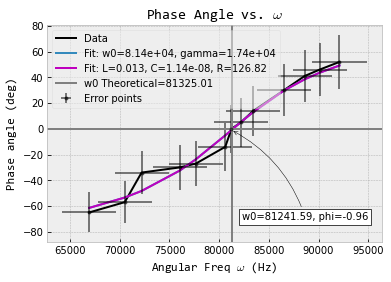

In [121]:
#style
hfont = {'fontname':'Consolas'}
plt.figure()
plt.style.use('bmh')



phifitline = Phifunc(w,*popt5)
phifitline2 = Phifunc2(w,*popt6)


def annot_max(x,y, ax=None):
    text= "w0={:.2f}, phi={:.2f}".format(x, y)
    if not ax:
        ax=plt.gca()
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    arrowprops=dict(arrowstyle="->",connectionstyle="arc3,rad=.2", color='black')
    kw = dict(xycoords='data',textcoords="axes fraction",
              arrowprops=arrowprops, bbox=bbox_props, ha="right", va="top")
    ax.annotate(text, xy=(x, y), xytext=(0.96,0.14), **kw)

annot_max(w[6],phifitline2[6])





#plot data
plt.plot(w,Phi, label = 'Data', color = 'black')
plt.plot(w,phifitline, label = 'Fit: w0=%1.2e, gamma=%1.2e' % tuple(popt5))
plt.plot(w,phifitline2, label = 'Fit: L=%1.3f, C=%1.2e, R=%1.2f' % tuple(popt6), color='m')
plt.errorbar(w,Phi,yerr=phistd, xerr=w0sig, fmt= '.', ls = None, label= 'Error points', color = 'black', alpha =0.5)


#Labels 
plt.title("Phase Angle vs. $\omega$", **hfont)
plt.ylabel("Phase angle (deg)", **hfont)
plt.xlabel("Angular Freq $\omega$ (Hz)", **hfont)
plt.axvline(w0, color ='gray', label =f'w0 Theoretical={w0:.2f}')
plt.axhline(0, color ='gray')

plt.legend(fancybox=True, framealpha=0.5)


# plt.savefig("PhiVsOmega.png", bbox_inches='tight')

# $Chi^2$

In [122]:
# By definition: 
chisq = sum( (Phi - phifitline2)**2 / phistd**2 )

# ndf = number of degrees of freedom
ndf = len(w)-len(popt6)

# prof advised not to use this 
chisq_reduced = chisq/float(ndf)

#   Note:
#       The reduced Chi2 = (Chi2/ndf) is just a "shortcut" that allows us to quickly decide if 
#       the data agrees with the model.
#     If reduced Chi2 is about equal to one: we are definitely good, because (Chi2/ndf)=1 corresponds to 
#     the p-value of 0.5

cdf = stat.chi2.cdf(chisq, df = ndf)

# For a Chisquare with a given number of degrees of freedom the p-test value: 
#       is just one minus the cummilative distribtion 
#       fucntion (CDF) of the chisquare probabilty distribution evaluated at the calculated value of ChiSq
pvalue = 1-cdf

print('Chi-square: ',chisq)
print('Degrees of freedom: ',ndf)
print('Reduced chi-square: ',chisq_reduced)
print('CDF: ', cdf)
print('p-test value: ',pvalue)

Chi-square:  1.1393549241326293
Degrees of freedom:  10
Reduced chi-square:  0.11393549241326292
CDF:  0.0003120571804579812
p-test value:  0.999687942819542


# Try 
> using the values obtained form the phi vs omega graph
$$
v_R(t) = R\cdot i(t) = R\cdot\frac{V_0}{R_T}
$$

$$
v_R(t) = R\cdot i(t) = R\cdot\frac{V_0}{R+R_L}
$$

In [116]:
print((R*(146/2)/Rt)) # we are off by a fucking factor of 10 (measure the R's one more time)

35.85334645669291


In [117]:
print(0.025/.5E-6)

50000.00000000001
